# probDE Tutorial
$$
\newcommand{\BB}{{\boldsymbol B}}
\newcommand{\cc}{{\boldsymbol c}}
\let\dd\relax
\newcommand{\dd}{{\boldsymbol d}}
\newcommand{\DD}{{\boldsymbol D}}
\newcommand{\Id}{{\boldsymbol I}}
\newcommand{\HH}{{\boldsymbol H}}
\newcommand{\RR}{{\boldsymbol R}}
\newcommand{\TT}{{\boldsymbol T}}
\newcommand{\VV}{{\boldsymbol V}}
\newcommand{\WW}{{\boldsymbol W}}
\newcommand{\ww}{{\boldsymbol w}}
\newcommand{\XX}{{\boldsymbol X}}
\newcommand{\xx}{{\boldsymbol x}}
\newcommand{\yy}{{\boldsymbol y}}
% Math Symbols
\newcommand{\rrh}{{\boldsymbol \rho}}
\newcommand{\lla}{{\boldsymbol \lambda}}
\newcommand{\ssi}{{\boldsymbol \sigma}}
\newcommand{\SSi}{{\boldsymbol \Sigma}}
\newcommand{\eps}{{\boldsymbol \epsilon}}
\newcommand{\GGa}{{\boldsymbol \Gamma}}
\newcommand{\bz}{{\boldsymbol 0}}
\DeclareMathOperator{\car}{CAR}
\newcommand{\N}{\mathcal N}
\newcommand{\iid}{\stackrel{iid}{\sim}}
\newcommand{\ud}{\, \mathrm{d}}
$$

This is a tutorial on the usage of the two types of priors that are listed in the README: Continuous Autoregressive (CAR(p)) process and non-Markov priors.

## CAR(p) Process

In [1]:
#Imports needed
from math import sin, cos
import numpy as np
import matplotlib.pyplot as plt

from BayesODE.Tests.root_gen import root_gen
from BayesODE.Kalman.kalman_initial_draw import kalman_initial_draw
from BayesODE.Kalman.higher_mvCond import higher_mvCond
from BayesODE.Kalman import kalman_ode_higher

The advantage of CAR(p) processes is that they are Markov, and so the probabilistic solver can be efficiently implemented in linear time using the [Kalman](https://en.wikipedia.org/wiki/Kalman_filter) filtering and smoothing recursions. As present, **probDE** can be used to solve any ODE initial value problem of the form

\begin{equation}
  \ww\xx_t = f(\xx_t, t) = 0, \qquad t \in [0, t_{max}], \qquad \xx_0 = x0,
\end{equation}

where $\xx_t = \big(x_t^{(0)}, x_t^{(1)}, ..., x_t^{(q)}\big)$ consists of the first q derivatives of the process, and a solution is sought on the interval $t \in [0, t_{max}]$. The CAR(p) solution prior is a continuous process of the form $\XX_t = \big(x_t^{(0)}, ..., x_t^{(p-1)}\big)$, where we should have $p > q$ so that it is smooth enough to solver the ODE above. We can write $\XX_t = (\xx_t, \yy_t)$ where $\yy_t = \big(x_t^{(q+1)}, ..., x_t^{(p-1)}\big)$. So we have

\begin{equation}
  \XX_t = (\xx_t, \yy_t) \sim \car_p(\lla, \rrh, \sigma),
\end{equation}

$\car_p(\rrh, \sigma)$ denotes a continuous autoregressive process with mean $\lla = (\lambda_1, ..., \lambda_p)$, roots $\rrh = (\rho_1, ..., \rho_p)$ and scale parameter $\sigma > 0$. For simplicity, we can redefine the IVP as:

\begin{equation}
  \WW\XX_t = f(\XX_t, t) = 0, \qquad t \in [0, t_{max}], \qquad \XX_0 = (x0, y0),
\end{equation}

where $\WW = (\ww, \bz_{p-q-1})$ and $y0$ will be drawn later in the tutorial.

As a simple example, consider the second order ODE initial value problem
\begin{align*}
x_t^{(2)} &= sin(2t) − x_t^{(0)} \\
x_0^{(1)} &= 0 \\
x_0^{(0)} &= −1
\end{align*}

Its exact solution is 
\begin{align*}
x_t^{(0)} &= (-3cos(t) + 2sin(t) - sin(2t))/3 \\
x_t^{(1)} &= (-2cos(2t) + 3sin(t) + 2cos(t))/3
\end{align*}

The equations to this IVP can be coded:

In [2]:
# RHS function in the IVP
def ode_F(X_t, t):
    return sin(2*t) - X_t[0] 

#Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

#Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In this example, we have $q=2$ since we have up to $x_t^{(2)}$ defined. We will use $p=4$ for this example. Now to setup the initial variables stated above we have:

In [3]:
# ODE definition
# LHS vector
w_vec = np.array([0, 0, 1.0])

# algorithm tuning parameters
q = 2 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior
W_vec = np.array([np.pad(w_vec, (0, p-q-1), 'constant', constant_values=(0,0))])

# it is assumed that the solution is sought on the interval [0,tmax].
# this next parameter specifies the size of the discretization grid
N = 100 
tmax = 10 
delta_t = np.array([tmax*1/N])

# Generate roots, rho, for the CAR(p) prior using root_gen
# #root_gen is a simple exponential function with the decorrelation r0 to generate p roots for CAR(p) prior
r0 = 0.01 # decorrelation parameter
roots = root_gen(r0, p) 

# now the tuning parameters of the CAR(p) prior
sigma = 0.0001 # scale paramater
lamb = np.zeros(p) #CAR(p) mean

#Initial Value x0
x0 = np.array([-1, 0, ode_F([-1, 0], 0)])

We now need to draw $y0$ for $\yy_0$ in the initial state $\XX_0$. We can do so by drawing $y0$ from their stationary CAR(p) distribution conditioned on $\xx_0 = x0$. We then have $\XX_0 \sim p(\N(\lla, \VV_{\infty}) | \xx_0=x0)$ and $\VV_{\infty}$ is derived from the $\car_p(\lla, \rrh, \sigma)$.

In [4]:
X0 = kalman_initial_draw(roots, sigma, x0, p)

Now the state space model we use to find our solution will be of the form:
\begin{align*}
  \XX_n &= \TT \XX_{n-1} + \cc + \RR^{1/2} \eps_n \\
  \yy_n &= \WW \XX_n + \HH^{1/2} \eta_n
\end{align*}

where $\eps_n \iid \N(\bz, \Id_p)$ are independent of $\eta_n \iid \N(\bz, \Id_p)$. 

Now we must define these parameters to calculate a probalistic solution to the IVP. $\HH^{1/2}$ is calculated in the function `kalman_ode_higher`, and we have already defined $\WW$ above as the variable `W_vec`. $\TT$ and $\RR$ can be derived from the CAR(p) process depending the grid size delta. Finally, $\cc = \lla - \TT \lla$.

In [6]:
# Define T, R in the state space model
# higher_mvCond uses the CAR(p) process to define the desired parameters
T, R = higher_mvCond(delta_t, roots, sigma) 
c = lamb - T.dot(lamb.T)

With everything defined, we can run the solver to get a realization, $\bar{\XX_t}$, of $\XX_t$ for $t \in [0, t_{max}]$, as well as the mean and variance of the distribution. Finally, we can get the a probablistic solution to the IVP, $\bar{\xx_t}$, in $\bar{\XX_t} = (\bar{\xx_t}, \bar{\yy_t})$.

In [7]:
Xn, Xn_mean, Xn_var = kalman_ode_higher(ode_F, X0, tmax, N-1, T, c, R, W_vec)

We can plot the probablistic solution for $x_t^{(0)}$ and $x_t^{(1)}$ to the exact solution to see how well the solver approximates.

In [8]:
tseq = np.linspace(0,10,N)
exact_x = np.zeros(N)
exact_x1 = np.zeros(N)
for t in range(N):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])

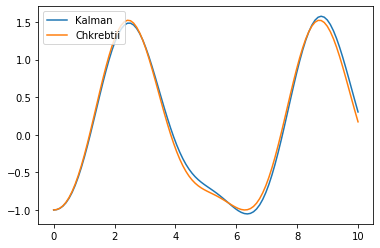

In [9]:
plt.plot(tseq, Xn[:,0], label = 'Kalman')
plt.plot(tseq, exact_x, label = 'Chkrebtii')
plt.legend(loc='upper left')

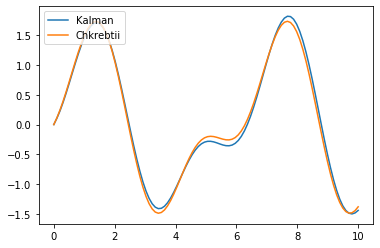

In [10]:
plt.plot(tseq, Xn[:,1], label = 'Kalman')
plt.plot(tseq, exact_x1, label = 'Chkrebtii')
plt.legend(loc='upper left')

## Non-Markov Priors

In [11]:
import BayesODE.Bayesian as bo
from scipy import integrate

For this method, we can only solve first order ODE problems of the form
\begin{equation}
  v_t = f(x_t,t)
\end{equation}
where $v_t = dx_t/dt$.

We use this simple example:

In [12]:
def ode_first(x, t):
    return  3*(t+1/4) - x/(t+1/4)

The initial values of the problem and the grid size can be defined as follows:

In [13]:
a = 0
b = 4.75
x0_f1 = 10
N = 100
tseq1 = np.linspace(a, b, N)

There are two parameters needed for this method. $\alpha$ is the covariance scale parameter and $\gamma$ is the decorrelation time such that $cov(v_t, v_{t+\gamma}) = 1/e$.

In [14]:
gamma = 0.1
alpha = 100

This method only requires the calculation of the initial covariance matrices: $cov(v_t, v_t)$, $cov(x_t, v_t)$ and $cov(x_t, x_t)$. Currently, we have 3 kernels to calculate these matrices: square exponential, exponential, and rectangular. For example we can use the square exponential kernel.

In [15]:
Sigma_vv = bo.cov_vv_se(tseq1, tseq1, gamma, alpha)
Sigma_xx = bo.cov_xx_se(tseq1, tseq1, gamma, alpha)
Sigma_xv = bo.cov_xv_se(tseq1, tseq1, gamma, alpha)

Once these matrices are calculated, we are ready to use the bayes solver.

In [16]:
xn, xn_mu, xn_var = bo.bayes_ode(ode_first, tseq1, x0_f1, Sigma_vv, Sigma_xx, Sigma_xv)

Again, we can plot the probablistic solution against the exact solution to see how well the solver approximates.

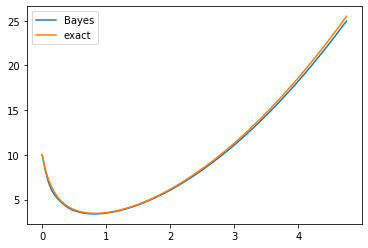

In [17]:
exact = integrate.odeint(ode_first,x0_f1,tseq1)
plt.plot(tseq1, xn, label = 'Bayes')
plt.plot(tseq1, exact, label='exact')
plt.legend(loc='upper left')
plt.show()